In [1]:
import time
import matplotlib.pyplot as plt

In this notebook, we use vectorisation to leverage our computer architecture in order to speed up computation.

The example used in this notebook is in the context of diffusion in fluids. More specifically, we are analysing the dynamics of how dye mixes with water if we put several drops in water at room temperature and without stirring the water. 

# Lists implementation

In [2]:
grid_shape = (1024, 1024)

def evolve(grid, dt, D = 1.0):
    '''
    Calculates the next state from the current state. 
    
    Parameters:
       - grid: current state
       - dt: time steps
       - D: dye's diffusion speed
    '''
    xmax, ymax = grid_shape
    new_grid = [[0.0,] * ymax for x in range(xmax)]
    for i in range(xmax): # Python 3 does not have xrange
            for j in range(ymax):
                # Gradients. Boundary condition: wrap around. 
                grid_xx = grid[(i + 1) % xmax][j] + grid[(i - 1) % xmax][j] - 2.0 * grid[i][j]
                grid_yy = grid[i][(j + 1) % ymax] + grid[i][(j - 1) % ymax] - 2.0 * grid[i][j]
                new_grid[i][j] = grid[i][j] + D * (grid_xx + grid_yy) * dt
    return new_grid

In [8]:
# Initialisation code. This code only runs once, as opposed to the previous function, that
# runs multiple times. That's why we will only analyse the complexity of the evolve function
def run_experiment(num_iterations):
    # Setting up initial conditions
    xmax, ymax = grid_shape
    grid = [[0.0, ] * ymax for x in range(xmax)]
    
    block_low = int(grid_shape[0] * .4)
    block_high = int(grid_shape[0] * .5)
    for i in range(block_low, block_high): # Python 3 does not have xrange
        for j in range(block_low, block_high):
            grid[i][j] = 0.005
            
    # Evolve the initial conditions
    start = time.time()
    for i in range(num_iterations):
        # The values in the grid and for dt have been chosen small enough so that
        # the algorithm will converge in a stable way
        grid = evolve(grid, 0.11)
    print(time.time() - start)
    
    return grid

7.152557373046875e-07
315.97924399375916
611.3518950939178


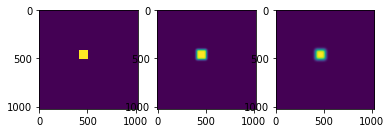

In [9]:
fig, ax = plt.subplots(1, 3)
for i in range(0,3):
    grid = run_experiment(i * 500)
    ax[i].imshow(grid)

## First quick optimisation

If we profile this code we will realise that most of the time is spent initialising `new_grid`. Allocating memory is expensive. Therefore. A first quick optimisation could be to take `new_grid` initialisation out from `evolve`, so it is initialised only once:

In [10]:
grid_shape = (1024, 1024)

def evolve(grid, dt, out, D = 1.0):
    '''
    Calculates the next state from the current state. 
    
    Parameters:
       - grid: current state
       - dt: time steps
       - D: dye's diffusion speed
    '''
    xmax, ymax = grid_shape
    for i in range(xmax): # Python 3 does not have xrange
            for j in range(ymax):
                # Gradients. Boundary condition: wrap around. 
                grid_xx = grid[(i + 1) % xmax][j] + grid[(i - 1) % xmax][j] - 2.0 * grid[i][j]
                grid_yy = grid[i][(j + 1) % ymax] + grid[i][(j - 1) % ymax] - 2.0 * grid[i][j]
                out[i][j] = grid[i][j] + D * (grid_xx + grid_yy) * dt

In [11]:
# Initialisation code. This code only runs once, as opposed to the previous function, that
# runs multiple times. That's why we will only analyse the complexity of the evolve function
def run_experiment(num_iterations):
    # Setting up initial conditions
    xmax, ymax = grid_shape
    next_grid = [[0.0,] * ymax for x in range(xmax)]
    grid = [[0.0, ] * ymax for x in range(xmax)]
    
    block_low = int(grid_shape[0] * .4)
    block_high = int(grid_shape[0] * .5)
    for i in range(block_low, block_high): # Python 3 does not have xrange
        for j in range(block_low, block_high):
            grid[i][j] = 0.005
            
    # Evolve the initial conditions
    start = time.time()
    for i in range(num_iterations):
        # The values in the grid and for dt have been chosen small enough so that
        # the algorithm will converge in a stable way
        evolve(grid, 0.11, next_grid)
        grid, next_grid = next_grid, grid
    print(time.time() - start)
    
    return grid

1.1920928955078125e-06
311.0722451210022
613.0756192207336


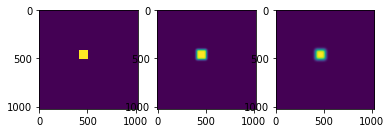

In [12]:
fig, ax = plt.subplots(1, 3)
for i in range(0,3):
    grid = run_experiment(i * 500)
    ax[i].imshow(grid)

There is some improvement, but not that much. We didn't get anything close to that 21% speed improvement demonstrated in the book. May it be because we are using Python 3?